In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import os
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

/home/femtomc/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


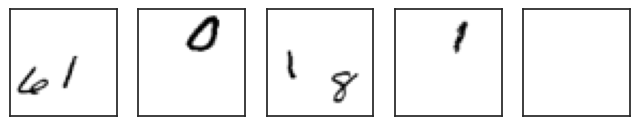

In [2]:
inpath = "./data/air/.data"
X_np, _ = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [3]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [4]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [5]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.1, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_enum(0.5 * prev_z_pres[0]) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [6]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()




├── :z_pres_1
│   └──  bool[]
├── :z_where_2
│   └──  f32[3]
├── :z_what_1
│   └──  f32[50]
├── :z_what_0
│   └──  f32[50]
├── :obs
│   └──  f32[50,50]
├── :z_pres_2
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_what_2
│   └──  f32[50]
├── :z_pres_0
│   └──  bool[]
└── :z_where_1
    └──  f32[3]

### Guide

In [7]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = grasp.flip_enum(z_pres_p[0] * prev_z_pres[0]) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [8]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()




├── :z_pres_1
│   └──  bool[]
├── :z_where_2
│   └──  f32[3]
├── :z_what_1
│   └──  f32[50]
├── :z_what_0
│   └──  f32[50]
├── :z_pres_2
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_what_2
│   └──  f32[50]
├── :z_pres_0
│   └──  bool[]
└── :z_where_1
    └──  f32[3]

## Training

### Make sure grads are working

#### Define ELBO objective

In [9]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)

#### Go go grads

In [10]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [11]:
loss

Array(-9797.152, dtype=float32)

In [12]:
for i in range(5):
    loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
        key, ((decoder,), (data, rnn, encoder, predict))
    )
    print(loss)

-9797.152
-9797.152
-9797.152
-9797.152
-9797.152


### Dataloader

In [13]:
def generators(
    data,
    split="train",
    shuffle=True,
):
    num_records = len(data[0])
    batch_size = num_records
    idxs = np.arange(num_records)

    def init():
        return (
            num_records // batch_size,
            np.random.permutation(idxs) if shuffle else idxs,
        )

    def get_batch(i=0, idxs=idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return tuple(
            np.take(a, ret_idx, axis=0)
            if isinstance(a, list)
            else jax.lax.index_take(a, (ret_idx,), axes=(0,))
            for a in data
        )

    return init, get_batch


def circular_data_loader(data, batch_size):
    M, N, H = data.shape
    num_complete_batches, leftover = divmod(M, batch_size)

    # Start with the complete batches
    batches = [
        data[i * batch_size : (i + 1) * batch_size] for i in range(num_complete_batches)
    ]

    # Handle the last batch if there's a leftover
    if leftover:
        last_batch = jnp.concatenate(
            [data[-leftover:], data[: batch_size - leftover]], axis=0
        )
        batches.append(last_batch)

    return generators(batches)

In [14]:
batch_size = 64
learning_rate = 1.0e-4
num_epochs = 5000


def svi_update(model, guide, optimiser):
    def batch_updater(key, params, opt_state, data_batch):
        def grads(key, params, data):
            (decoder, rnn, encoder, predict) = params
            data = genjax.choice_map({"obs": data})
            objective = grasp.elbo(model, guide, data)
            loss, (
                (decoder_grads,),
                (_, rnn_grads, encoder_grads, predict_grads),
            ) = objective.value_and_grad_estimate(
                key, ((decoder,), (data, rnn, encoder, predict))
            )
            return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

        sub_keys = jax.random.split(key, len(data_batch))
        loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
            grads, in_axes=(0, None, 0)
        )(sub_keys, params, data_batch)

        grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0),
            (decoder_grads, rnn_grads, encoder_grads, predict_grads),
        )
        updates, opt_state = optimiser.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss = jnp.mean(loss)
        return params, opt_state, loss

    return batch_updater


adam = optax.adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = circular_data_loader(mnist, batch_size)
num_train, train_idx = train_init()


@jax.jit
def epoch_train(opt_state, params, key, train_idx):
    def body_fn(carry, xs):
        idx, params, opt_state, loss = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)[0]
        params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
        idx += 1
        return (idx, params, opt_state, loss), loss

    idx = 0
    (_, params, opt_state, _), losses = jax.lax.scan(
        body_fn, (idx, params, opt_state, 0.0), None, length=num_train
    )
    return params, opt_state, losses


# Train.
key = jax.random.PRNGKey(314159)
params = (decoder, rnn, encoder, predict)
opt_state = adam.init(params)
for i in range(0, num_epochs):
    key, sub_key = jax.random.split(key)
    num_train, train_idx = train_init()
    params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
    if i % 100 == 0:
        print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))

-3995.6584 -3995.6584 -3995.6584
-1172.2957 -1172.2957 -1172.2957
-459.3874 -459.3874 -459.3874
87.91424 87.91424 87.91424
210.9973 210.9973 210.9973
288.83783 288.83783 288.83783
301.24286 301.24286 301.24286
309.26553 309.26553 309.26553
318.3954 318.3954 318.3954
331.2666 331.2666 331.2666
337.13907 337.13907 337.13907
310.04376 310.04376 310.04376
363.90253 363.90253 363.90253
360.7375 360.7375 360.7375
342.77277 342.77277 342.77277
374.1248 374.1248 374.1248
373.64056 373.64056 373.64056
379.5707 379.5707 379.5707
391.8756 391.8756 391.8756
407.89407 407.89407 407.89407
412.64627 412.64627 412.64627
426.8839 426.8839 426.8839
428.96808 428.96808 428.96808
436.68213 436.68213 436.68213
449.09302 449.09302 449.09302
455.69467 455.69467 455.69467
458.3228 458.3228 458.3228
466.5017 466.5017 466.5017
470.156 470.156 470.156
470.1621 470.1621 470.1621
473.21207 473.21207 473.21207
474.06995 474.06995 474.06995
475.23865 475.23865 475.23865
475.9619 475.9619 475.9619
477.8496 477.8496 4

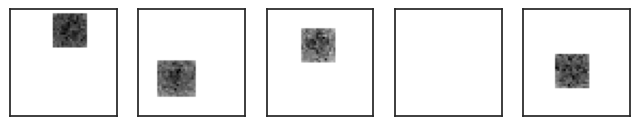

In [15]:
(trained_decoder, _, _, _) = params
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, (trained_decoder,))
generated = tr.get_retval()
show_images(generated)